In [1]:
import os 
import random  

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set reprodicibility

seed = 41

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Dataset loading

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True,
                                                                                                group_numbers=True)


In [5]:
from utils.vocabulary_builder import create_vocabulary

texts = texts_train + texts_val + texts_test

vocabulary, x = create_vocabulary(texts=texts)

x_train, x_val, x_test = (x[0:len(texts_train)], x[len(texts_train):len(texts_train)+len(texts_val)],
                                                    x[len(texts_train)+len(texts_val):])

In [6]:
from utils.vocabulary_builder import create_vocabulary

labels = labels_train + labels_val + labels_test

vocabulary_labels, y = create_vocabulary(texts=labels)

y_train, y_val, y_test = (y[0:len(labels_train)], y[len(labels_train):len(labels_train)+len(labels_val)],
                                                    y[len(labels_train)+len(labels_val):])

n_classes = len(vocabulary_labels)

# The punctuation POS tags
punctuation_tags = [',', '.', ':', '``', "''"]
# POS tags to not evaluate: punctuation tags + padding
tags_no_evaluate = punctuation_tags + ['']

In [161]:
vocabulary_labels

array(['', 'NN', 'IN', 'NNP', 'DT', 'NNS', 'JJ', ',', '.', 'CD', 'VBD',
       'RB', 'VB', 'CC', 'TO', 'VBN', 'VBZ', 'PRP', 'VBG', 'VBP', 'MD',
       'POS', 'PRP$', '$', '``', "''", ':', 'WDT', 'JJR', 'NNPS', 'WP',
       'RP', 'JJS', 'WRB', 'RBR', '-RRB-', '-LRB-', 'EX', 'RBS', 'PDT',
       '#', 'WP$', 'LS', 'FW', 'UH', 'SYM'], dtype='<U5')

In [7]:
from utils.data_generator import DataGenerator

train_gen = DataGenerator(texts=x_train, labels=y_train)

val_gen = DataGenerator(texts=x_val, labels=y_val, shuffle=False)

In [8]:
x_val_padded, y_val_padded = DataGenerator(texts=x_val, labels=y_val, batch_size=len(x_val), shuffle=False)[0]
x_test_padded, y_test_padded = DataGenerator(texts=x_test, labels=y_test, batch_size=len(x_test), shuffle=False)[0]
x_test_padded.shape

(638, 80)

### Analysis of the training set

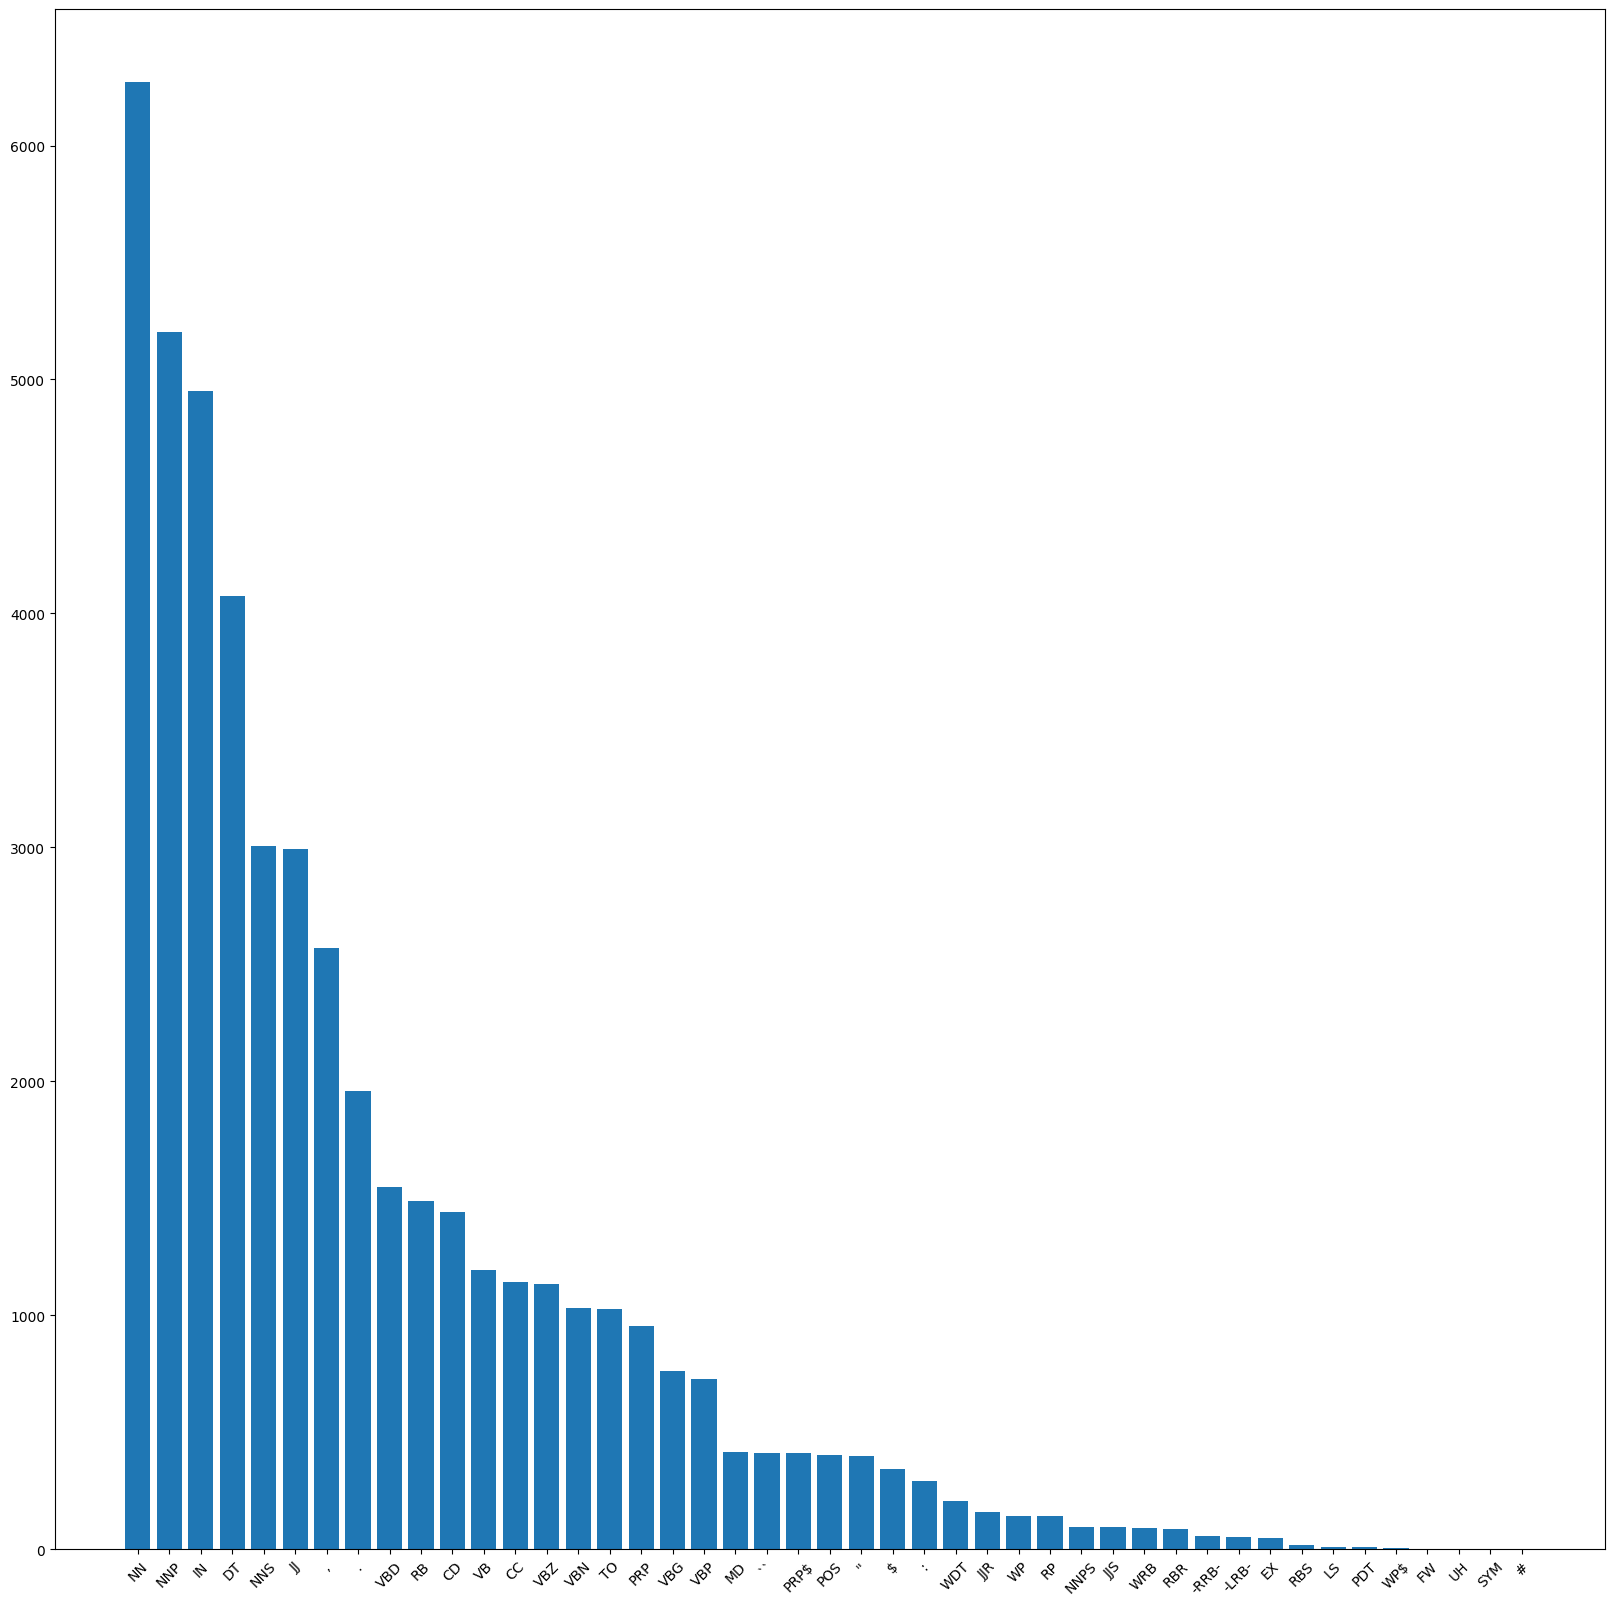

In [9]:
# Distribution of the POS tags

from collections import Counter

labels_train_flat = [label for labels in labels_train for label in labels]
POS_tags = np.array(list(Counter(labels_train_flat).keys())) # equals to list(set(words))
POS_tags_counts = list(Counter(labels_train_flat).values()) # counts the elements' frequency

POS_tags = POS_tags[np.argsort(POS_tags_counts)][::-1]
POS_tags_counts = sorted(POS_tags_counts)[::-1]

plt.figure(figsize=(20,20))
plt.bar(POS_tags, POS_tags_counts)
plt.xticks(rotation = 45)
plt.show()

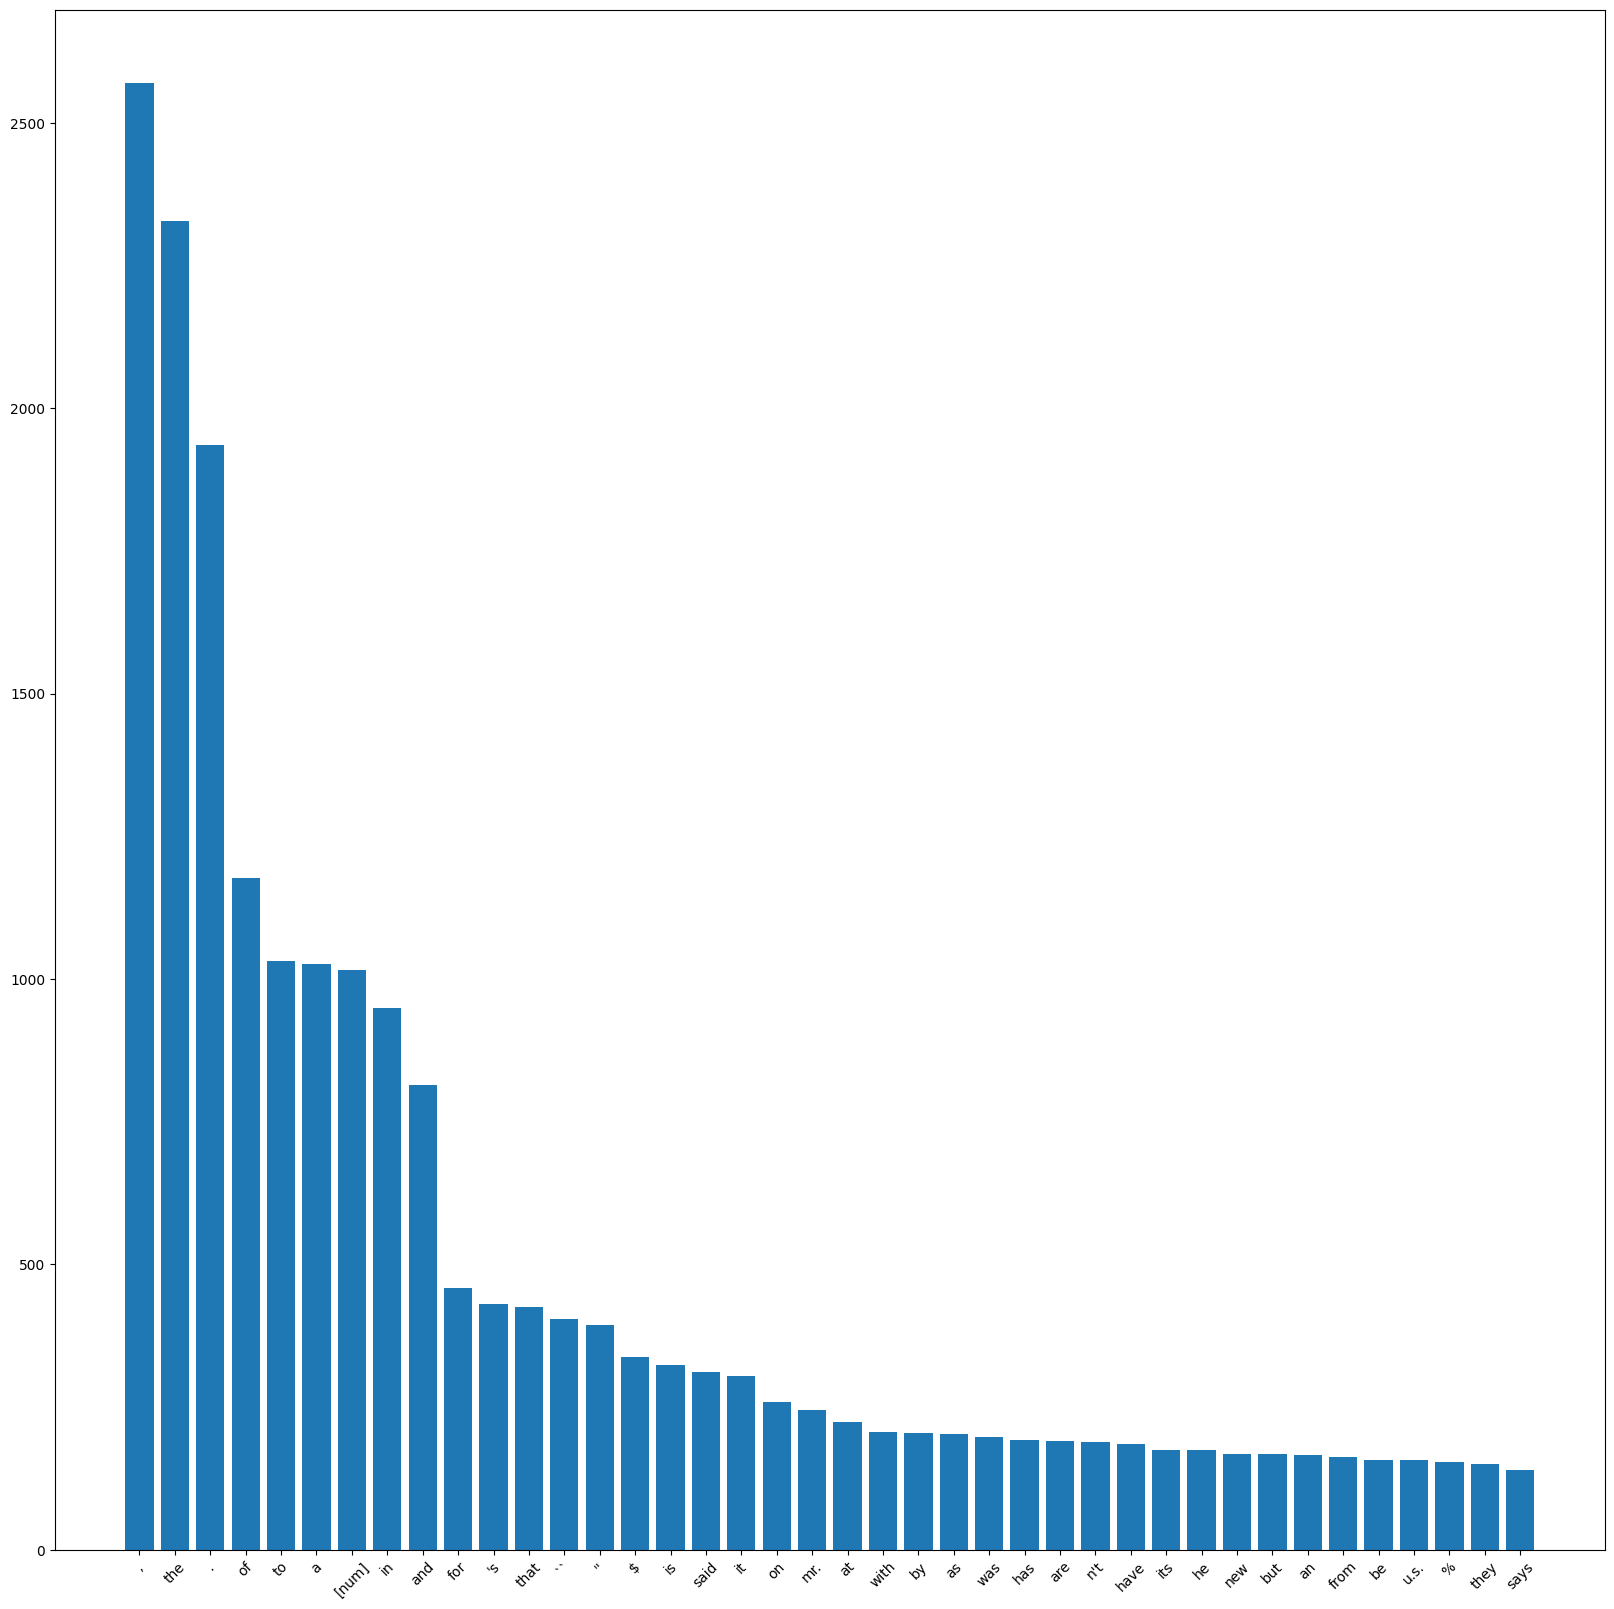

In [10]:
# Distribution of the POS tags

from collections import Counter

tokens_train_flat = [word for text in texts_train for word in text]
tokens = np.array(list(Counter(tokens_train_flat).keys())) # equals to list(set(words))
tokens_counts = list(Counter(tokens_train_flat).values()) # counts the elements' frequency

tokens = tokens[np.argsort(tokens_counts)][::-1]
tokens_counts = sorted(tokens_counts)[::-1]

plt.figure(figsize=(20,20))
plt.bar(tokens[:40], tokens_counts[:40])
plt.xticks(rotation = 45)
plt.show()

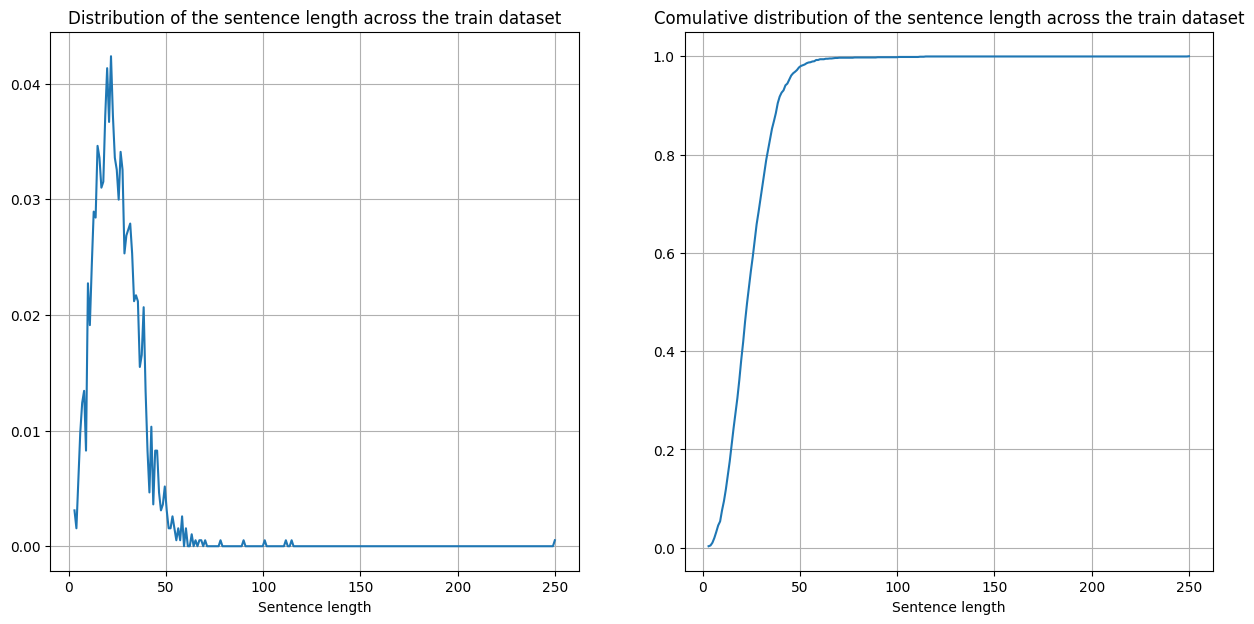

In [11]:
# Analysis of the sentences length (i.e. number of tokens) 

# Length of each training sentence
train_sentences_lenghts = [len(sentence) for sentence in texts_train]

# Histogram of the sentences length distribution
hist, bin_edges = np.histogram(train_sentences_lenghts, bins=np.max(train_sentences_lenghts) + 1, density=True) 
# Cumulative distribution of the sentences length
C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(bin_edges[1:], hist)
plt.title('Distribution of the sentence length across the train dataset')
plt.xlabel('Sentence length')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(bin_edges[1:], C)
plt.title('Comulative distribution of the sentence length across the train dataset')
plt.xlabel('Sentence length')
plt.grid()
plt.show()

### Glove embeddings

In [12]:
from utils.embedding_model_handler import load_embedding_model

embedding_dimension = 50

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension, extended_version=True)

In [13]:
print(len(GLOVE_embeddings))

400547


### Embedding matrix

In [14]:
from utils.embedding_matrix_builder import build_embedding_matrix

embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, 
                                          embedding_dimension=embedding_dimension)

### Training callbacks

In [15]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=4,
                                            min_delta=1e-3,
                                            restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_delta=1e-3)

## First dumb classifier: majority class
We define a dumb classifier, which always returns as predicted POS tag the most frequent POS tag present in the training set.

In [16]:
most_common_label = POS_tags[np.argmax(POS_tags_counts)]
most_common_label_index = np.where(vocabulary_labels==most_common_label)[0][0]
print(f'Most common POS tag ==> label : {most_common_label}; index : {most_common_label_index}')

Most common POS tag ==> label : NN; index : 1


In [17]:
# Val

from utils.evaluate import compute_f1_score, compute_class_report

y_pred_val = np.array([[most_common_label_index for _ in range(y_val_padded.shape[1])] for _ in range(y_val_padded.shape[0])])

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro val: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.16      1.00      0.28      4513
          IN       0.00      0.00      0.00      3275
         NNP       0.00      0.00      0.00      2704
          DT       0.00      0.00      0.00      2754
         NNS       0.00      0.00      0.00      2102
          JJ       0.00      0.00      0.00      1924
          CD       0.00      0.00      0.00      1249
         VBD       0.00      0.00      0.00       861
          RB       0.00      0.00      0.00       951
          VB       0.00      0.00      0.00       956
          CC       0.00      0.00      0.00       758
          TO       0.00      0.00      0.00       765
         VBN       0.00      0.00      0.00       737
         VBZ       0.00      0.00      0.00       712
         PRP       0.00      0.00      0.00       570
         VBG       0.00      0.00      0.00       476
         VBP       0.00      0.00      0.00       460
          MD       0.00    

In [18]:
# Test

y_pred_test = np.array([[most_common_label_index for _ in range(y_test_padded.shape[1])] for _ in range(y_test_padded.shape[0])])

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro test: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.17      1.00      0.29      2383
          IN       0.00      0.00      0.00      1630
         NNP       0.00      0.00      0.00      1504
          DT       0.00      0.00      0.00      1335
         NNS       0.00      0.00      0.00       941
          JJ       0.00      0.00      0.00       918
          CD       0.00      0.00      0.00       858
         VBD       0.00      0.00      0.00       634
          RB       0.00      0.00      0.00       381
          VB       0.00      0.00      0.00       403
          CC       0.00      0.00      0.00       366
          TO       0.00      0.00      0.00       386
         VBN       0.00      0.00      0.00       366
         VBZ       0.00      0.00      0.00       280
         PRP       0.00      0.00      0.00       192
         VBG       0.00      0.00      0.00       221
         VBP       0.00      0.00      0.00       134
          MD       0.00    

## Baseline Model

In [19]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [20]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          503500    
                                                                 
 bidirectional (Bidirectiona  [(None, None, 256),      183296    
 l)                           (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense (Dense)               (None, None, 46)          11822     
                                                                 
Total params: 698,618
Trainable params: 195,118
Non-trainable

In [21]:
baseline_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [22]:
weigths_dir = os.path.join('weigths', 'baselineModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsBaselineModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
baseline_model_history = baseline_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 63s 313ms/step - loss: 1.2038 - accuracy: 0.3091 - val_loss: 0.9720 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 93ms/step - loss: 0.7396 - accuracy: 0.5929 - val_loss: 0.6222 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 6s 90ms/step - loss: 0.5158 - accuracy: 0.7138 - val_loss: 0.4942 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 6s 95ms/step - loss: 0.4224 - accuracy: 0.7559 - val_loss: 0.4309 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 6s 94ms/step - loss: 0.3655 - accuracy: 0.7821 - val_loss: 0.3868 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 104ms/step - loss: 0.3224 - accuracy: 0.8026 - val_loss: 0.3600 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 102ms/step - loss:

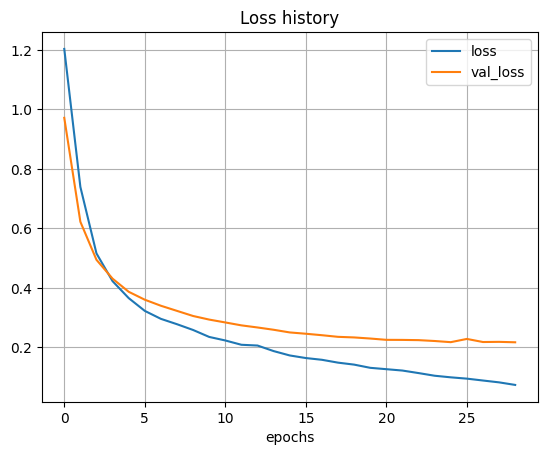

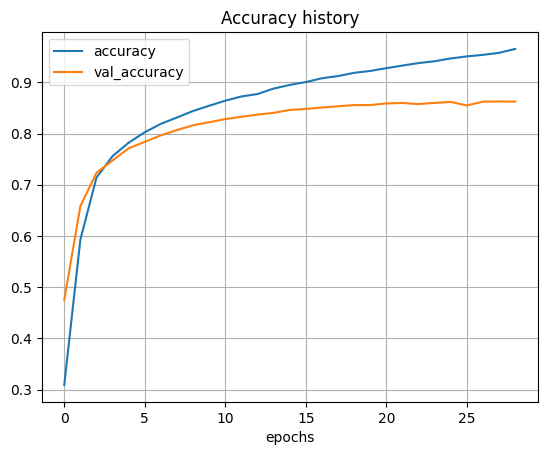

In [24]:
from utils.evaluate import plot_history

plot_history(baseline_model_history)

### Check the predicted labels on a single test sentence

In [25]:
print('Sentence:', texts_test[0])

Sentence: ['intelogic', 'trace', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '[num]', 'million', 'shares', ',', 'or', 'about', '[num]', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', 'unaffiliated', 'shareholder', 'for', '$', '[num]', 'a', 'share', ',', 'or', '$', '[num]', 'million', '.']


In [26]:
print('True POS tags:', labels_test[0])

True POS tags: ['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.']


In [27]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(baseline_model(x_test_padded[0:1]), axis=2)][0][:len(labels_test[0])])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [28]:
baseline_model.evaluate(x_test_padded, y_test_padded)

20/20 [==============================] - 1s 34ms/step - loss: 0.1227 - accuracy: 0.8746


[0.12266847491264343, 0.8746220469474792]

### F1 macro (no punctuation)

In [29]:
# Val

y_pred_val = np.argmax(baseline_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro val: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.78      0.83      0.81      4503
          IN       0.93      0.94      0.94      3274
         NNP       0.81      0.84      0.83      2703
          DT       0.97      0.98      0.97      2754
         NNS       0.81      0.81      0.81      2101
          JJ       0.68      0.69      0.68      1921
          CD       0.96      0.94      0.95      1249
         VBD       0.85      0.79      0.82       861
          RB       0.66      0.70      0.68       951
          VB       0.86      0.86      0.86       955
          CC       0.97      0.95      0.96       758
          TO       0.99      1.00      0.99       765
         VBN       0.68      0.64      0.66       737
         VBZ       0.93      0.87      0.90       711
         PRP       0.94      0.97      0.96       570
         VBG       0.59      0.46      0.52       476
         VBP       0.82      0.75      0.78       460
          MD       0.96    

In [30]:
# Test

y_pred_test = np.argmax(baseline_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

class_report, _ = compute_class_report(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro test: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.80      0.83      0.82      2380
          IN       0.94      0.94      0.94      1630
         NNP       0.82      0.86      0.84      1503
          DT       0.98      0.98      0.98      1335
         NNS       0.80      0.83      0.81       941
          JJ       0.70      0.67      0.68       918
          CD       0.97      0.97      0.97       857
         VBD       0.89      0.81      0.85       634
          RB       0.68      0.68      0.68       381
          VB       0.87      0.93      0.90       403
          CC       0.96      0.98      0.97       365
          TO       1.00      1.00      1.00       386
         VBN       0.74      0.67      0.70       366
         VBZ       0.88      0.88      0.88       280
         PRP       0.95      0.98      0.96       192
         VBG       0.62      0.48      0.54       221
         VBP       0.84      0.73      0.78       134
          MD       0.94    

In [31]:
sorted([(class_report[label]['f1-score'], label) for label in class_report.keys() if label not in ['accuracy','macro avg','weighted avg'] ])

[(0.0, 'NNPS'),
 (0.0, 'PDT'),
 (0.33333333333333337, 'RBR'),
 (0.4, 'WP$'),
 (0.544529262086514, 'VBG'),
 (0.5609756097560976, 'RP'),
 (0.607843137254902, 'JJR'),
 (0.6382978723404255, 'JJS'),
 (0.6666666666666667, 'WRB'),
 (0.6815789473684211, 'RB'),
 (0.6844444444444445, 'JJ'),
 (0.7031700288184437, 'VBN'),
 (0.7499999999999999, 'RBS'),
 (0.784, 'VBP'),
 (0.8135064935064935, 'NNS'),
 (0.8155940594059405, 'NN'),
 (0.840872111942727, 'NNP'),
 (0.8476821192052979, 'VBD'),
 (0.875, 'VBZ'),
 (0.8979591836734693, 'VB'),
 (0.9268292682926829, 'WP'),
 (0.9364161849710984, 'WDT'),
 (0.9410326917201344, 'IN'),
 (0.9411764705882353, '-RRB-'),
 (0.9473684210526316, '-LRB-'),
 (0.9641025641025641, 'PRP'),
 (0.9649122807017544, 'MD'),
 (0.9658536585365853, 'PRP$'),
 (0.9687924016282226, 'CC'),
 (0.9690239625949736, 'CD'),
 (0.9790888722927559, 'DT'),
 (0.9934640522875817, 'POS'),
 (0.9987063389391979, 'TO'),
 (1.0, '$'),
 (1.0, 'EX')]

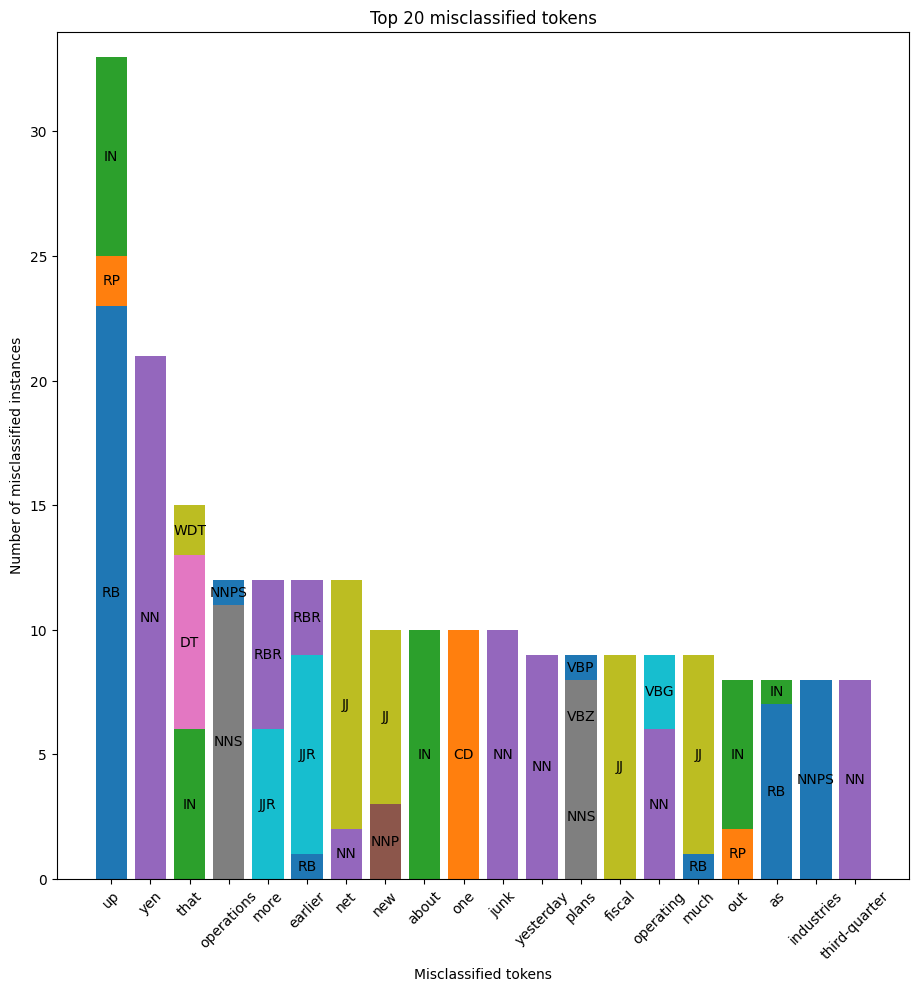

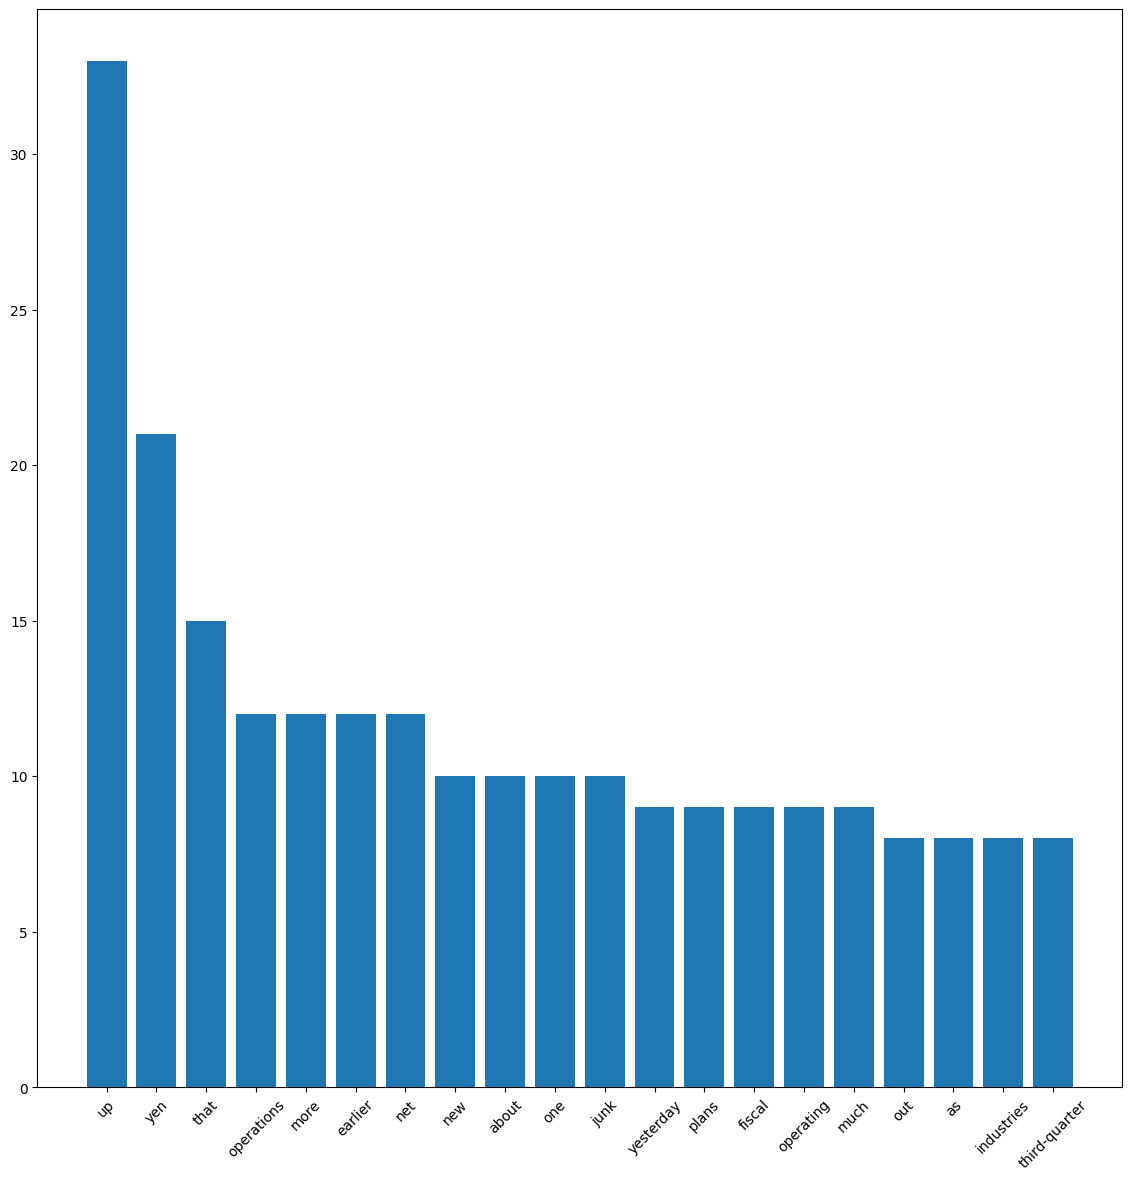

In [32]:
from utils.evaluate import wrongly_classified_tokens_analysis
wrong_tokens, wrong_tokens_counts, _ = wrongly_classified_tokens_analysis(x_test_padded, y_test_padded, y_pred_test, tags_no_evaluate, vocabulary_labels, vocabulary)

plt.figure(figsize=(14,14))
plt.bar(wrong_tokens[:20], wrong_tokens_counts[:20])
plt.xticks(rotation = 45)
plt.show()

## First Model

In [33]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [34]:
first_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          503500    
                                                                 
 bidirectional_1 (Bidirectio  [(None, None, 256),      138240    
 nal)                         (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_1 (Dense)             (None, None, 46)          11822     
                                                                 
Total params: 653,562
Trainable params: 150,062
Non-trainable params: 503,500
_________________________________________________________________


In [35]:
weigths_dir = os.path.join('weigths', 'firstModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsFirstModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
first_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [37]:
first_model_history = first_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 53s 306ms/step - loss: 1.1108 - accuracy: 0.3878 - val_loss: 0.7738 - val_accuracy: 0.5774 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 97ms/step - loss: 0.5727 - accuracy: 0.6791 - val_loss: 0.5108 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 6s 94ms/step - loss: 0.4203 - accuracy: 0.7556 - val_loss: 0.4150 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 6s 101ms/step - loss: 0.3499 - accuracy: 0.7894 - val_loss: 0.3663 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 5s 90ms/step - loss: 0.3049 - accuracy: 0.8145 - val_loss: 0.3362 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 92ms/step - loss: 0.2715 - accuracy: 0.8301 - val_loss: 0.3125 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 97ms/step - loss: 

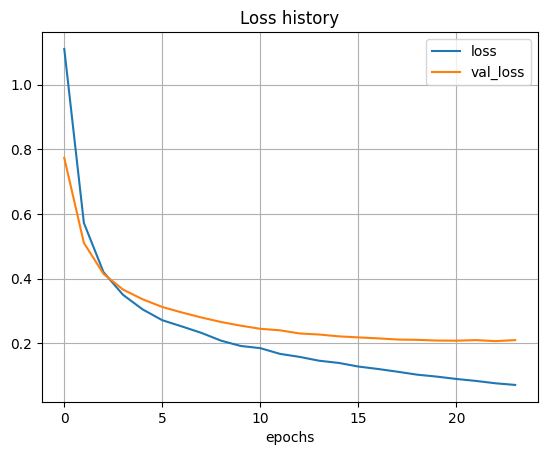

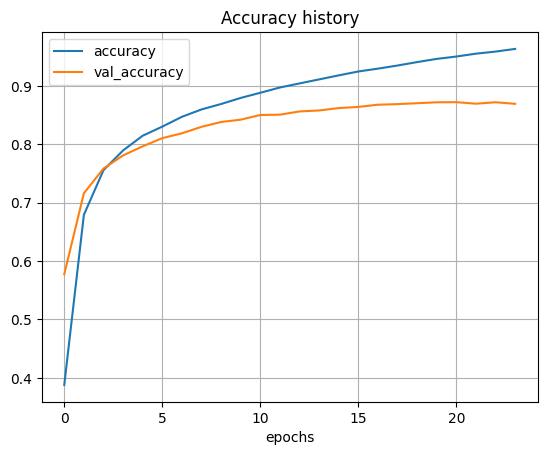

In [38]:
from utils.evaluate import plot_history

plot_history(first_model_history)

### Check the predicted labels on a single test sentence

In [39]:
print('Sentence:', texts_test[0])

Sentence: ['intelogic', 'trace', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '[num]', 'million', 'shares', ',', 'or', 'about', '[num]', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', 'unaffiliated', 'shareholder', 'for', '$', '[num]', 'a', 'share', ',', 'or', '$', '[num]', 'million', '.']


In [40]:
print('True POS tags:', labels_test[0])

True POS tags: ['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.']


In [41]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(first_model(x_test_padded[0:1]), axis=2)][0][:len(labels_test[0])])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [42]:
first_model.evaluate(x_test_padded, y_test_padded)

20/20 [==============================] - 1s 41ms/step - loss: 0.1169 - accuracy: 0.8831


[0.11689011007547379, 0.8831135630607605]

### F1 macro (no punctuation)

In [43]:
# Val

y_pred_val = np.argmax(first_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro val: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.78      0.86      0.82      4508
          IN       0.96      0.93      0.95      3275
         NNP       0.86      0.83      0.84      2701
          DT       0.98      0.98      0.98      2754
         NNS       0.82      0.84      0.83      2102
          JJ       0.67      0.70      0.69      1923
          CD       0.97      0.95      0.96      1249
         VBD       0.84      0.82      0.83       861
          RB       0.66      0.76      0.71       951
          VB       0.90      0.85      0.87       955
          CC       0.96      0.96      0.96       758
          TO       1.00      1.00      1.00       765
         VBN       0.76      0.62      0.68       737
         VBZ       0.89      0.88      0.88       712
         PRP       0.97      0.98      0.98       570
         VBG       0.62      0.47      0.53       475
         VBP       0.81      0.77      0.79       460
          MD       0.97    

In [44]:
# Test

y_pred_test = np.argmax(first_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro test: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.80      0.86      0.83      2382
          IN       0.96      0.94      0.95      1630
         NNP       0.86      0.85      0.85      1502
          DT       0.98      0.98      0.98      1335
         NNS       0.80      0.84      0.82       941
          JJ       0.69      0.67      0.68       918
          CD       0.98      0.98      0.98       857
         VBD       0.89      0.86      0.88       634
          RB       0.68      0.75      0.71       381
          VB       0.90      0.92      0.91       403
          CC       0.98      0.99      0.98       365
          TO       1.00      1.00      1.00       386
         VBN       0.78      0.65      0.71       366
         VBZ       0.85      0.90      0.87       280
         PRP       0.97      0.98      0.98       192
         VBG       0.69      0.49      0.58       221
         VBP       0.86      0.73      0.79       134
          MD       0.96    

## Second Model

In [45]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_matrix=embedding_matrix, dropout=0.2)

In [47]:
#second_model.load_weights('weigths/secondModel/weightsSecondModel.22-0.41.hdf5')

In [48]:
second_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          503500    
                                                                 
 bidirectional_2 (Bidirectio  [(None, None, 256),      183296    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 bidirectional_3 (Bidirectio  [(None, None, 256),      394240    
 nal)                         (None, 128),                       
                              (None, 128),                 

In [49]:
weigths_dir = os.path.join('weigths', 'secondModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsSecondModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [50]:
second_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [51]:
second_model_history = second_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 106s 560ms/step - loss: 1.2340 - accuracy: 0.2443 - val_loss: 1.0106 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 11s 175ms/step - loss: 0.7541 - accuracy: 0.5474 - val_loss: 0.5943 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 10s 171ms/step - loss: 0.5283 - accuracy: 0.6799 - val_loss: 0.4631 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 11s 176ms/step - loss: 0.4381 - accuracy: 0.7280 - val_loss: 0.3994 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 11s 173ms/step - loss: 0.3832 - accuracy: 0.7589 - val_loss: 0.3605 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 11s 174ms/step - loss: 0.3363 - accuracy: 0.7830 - val_loss: 0.3279 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 11s 182ms/s

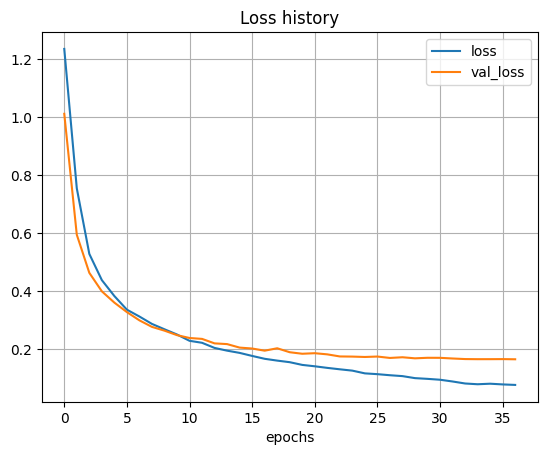

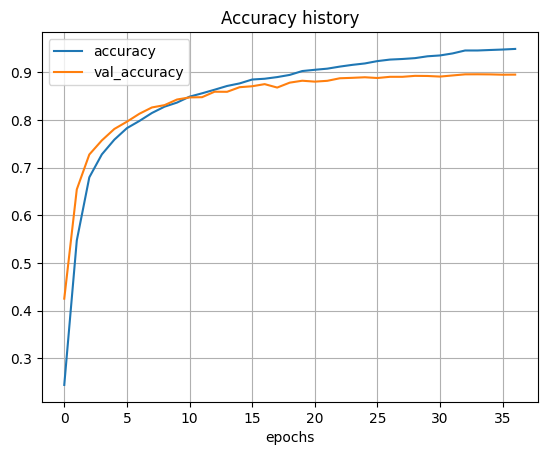

In [52]:
from utils.evaluate import plot_history

plot_history(second_model_history)

### Check the predicted labels on a single test sentence

In [53]:
print('Sentence:', texts_test[0])

Sentence: ['intelogic', 'trace', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '[num]', 'million', 'shares', ',', 'or', 'about', '[num]', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', 'unaffiliated', 'shareholder', 'for', '$', '[num]', 'a', 'share', ',', 'or', '$', '[num]', 'million', '.']


In [54]:
print('True POS tags:', labels_test[0])

True POS tags: ['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.']


In [55]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(second_model(x_test_padded[0:1]), axis=2)][0][:len(labels_test[0])])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [56]:
second_model.evaluate(x_test_padded, y_test_padded)

20/20 [==============================] - 1s 55ms/step - loss: 0.0939 - accuracy: 0.9038


[0.09385117143392563, 0.9037632942199707]

### F1 macro (no punctuation)

In [57]:
# Val

y_pred_val = np.argmax(second_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

_, _ = compute_class_report(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                                       vocabulary_labels=vocabulary_labels, show=True, plot=False)

print('F1 macro val: {:.3f}'.format(f1_macro))

              precision    recall  f1-score   support

          NN       0.83      0.86      0.84      4509
          IN       0.96      0.96      0.96      3275
         NNP       0.89      0.85      0.87      2702
          DT       0.98      0.99      0.99      2754
         NNS       0.85      0.85      0.85      2102
          JJ       0.72      0.77      0.74      1924
          CD       0.99      0.98      0.98      1249
         VBD       0.88      0.86      0.87       861
          RB       0.77      0.81      0.79       951
          VB       0.91      0.90      0.91       954
          CC       0.99      0.97      0.98       758
          TO       0.99      1.00      1.00       765
         VBN       0.79      0.71      0.75       737
         VBZ       0.95      0.91      0.93       712
         PRP       0.97      0.99      0.98       570
         VBG       0.65      0.61      0.63       476
         VBP       0.85      0.83      0.84       460
          MD       0.97    

In [58]:
# Test

from utils.evaluate import compute_f1_score, compute_class_report

y_pred_test = np.argmax(second_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)
                            
print('F1 macro test: {:.3f}'.format(f1_macro))

F1 macro test: 0.832


              precision    recall  f1-score   support

          NN       0.84      0.86      0.85      2383
          IN       0.97      0.95      0.96      1630
         NNP       0.88      0.86      0.87      1504
          DT       0.98      0.99      0.99      1335
         NNS       0.82      0.87      0.84       941
          JJ       0.75      0.77      0.76       918
          CD       0.98      0.99      0.99       858
         VBD       0.92      0.91      0.91       633
          RB       0.76      0.82      0.79       381
          VB       0.91      0.95      0.93       402
          CC       0.98      0.99      0.99       365
          TO       0.99      1.00      1.00       386
         VBN       0.78      0.68      0.73       366
         VBZ       0.90      0.91      0.90       280
         PRP       0.98      0.99      0.99       192
         VBG       0.69      0.59      0.64       221
         VBP       0.85      0.80      0.82       134
          MD       0.97    

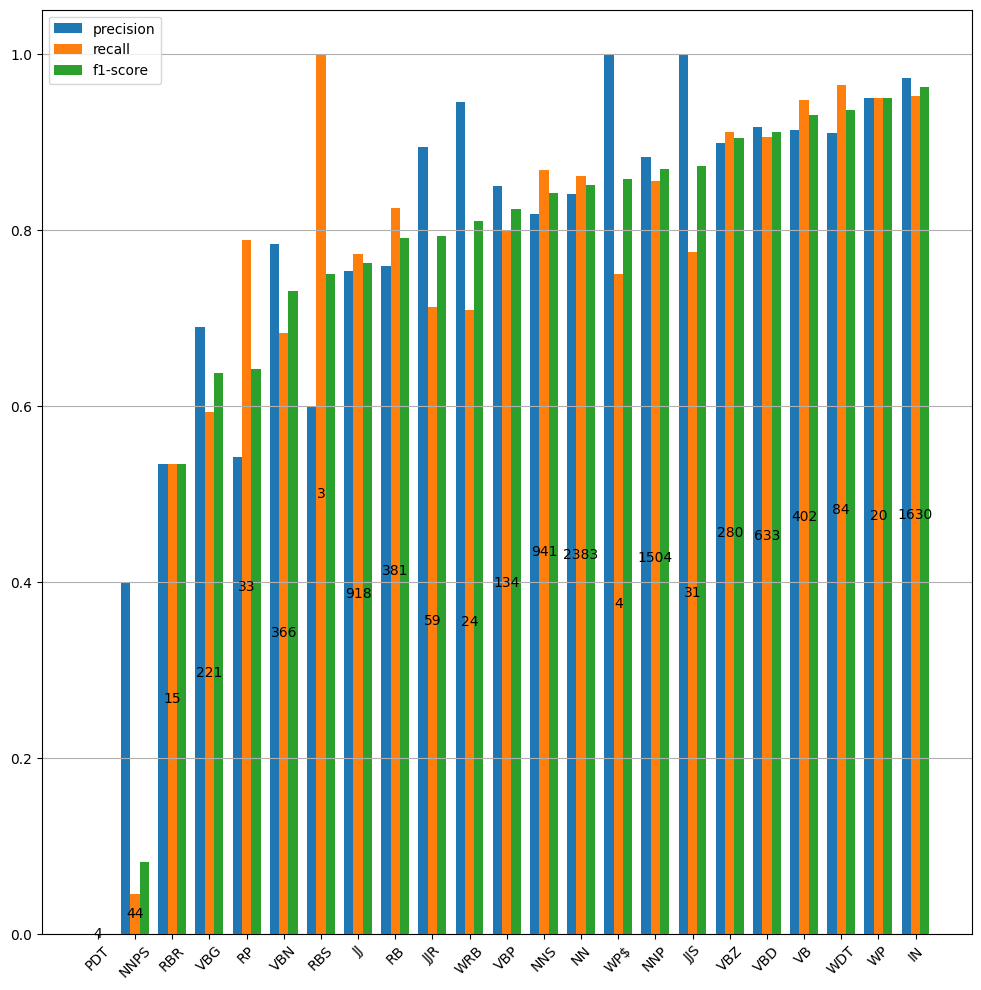

In [59]:
class_report, worst_predicted_tags = compute_class_report(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate, 
                                    vocabulary_labels=vocabulary_labels, show=True)

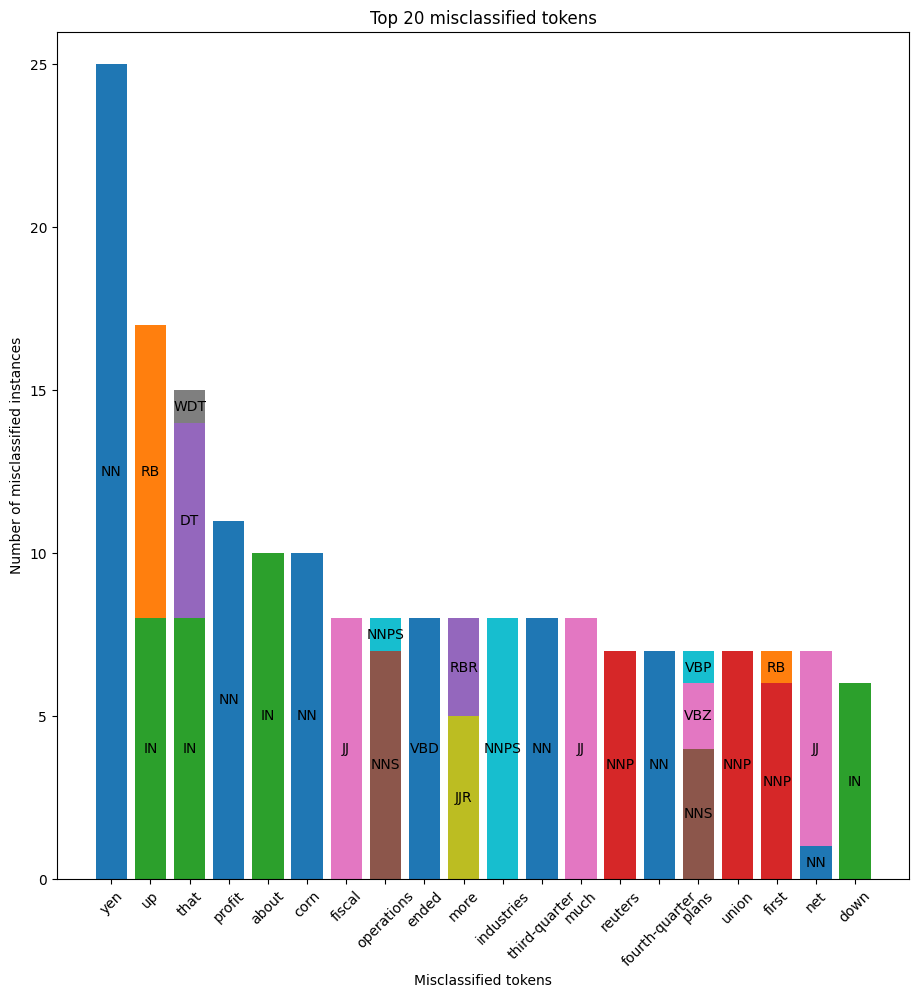

In [60]:
from utils.evaluate import wrongly_classified_tokens_analysis

wrong_tokens, wrong_tokens_counts, wrong_tokens_tags_df = wrongly_classified_tokens_analysis(x_test_padded, y_true=y_test_padded, y_pred=y_pred_test, 
                                                                       tags_no_evaluate=tags_no_evaluate, vocabulary_labels=vocabulary_labels,
                                                                       vocabulary=vocabulary)

In [61]:
'''from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

def plot_roc_curve(y_true, y_pred, tags_no_evaluate, target_calsses, vocabulary_labels):
    ids_no_evaluate = [i for i, pos_tag in enumerate(vocabulary_labels) if pos_tag in tags_no_evaluate]
    ids_target_calsses = [i for i, pos_tag in enumerate(vocabulary_labels) if pos_tag in target_calsses]

    def f(v, tags=ids_no_evaluate):
        return v in tags
    
    mask = np.vectorize(f)(y_true)
    mask = np.logical_or(mask, np.vectorize(f)(y_pred))
 
    y_true = y_true[~mask]
    y_pred = y_pred[~mask]
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    for i in ids_target_calsses:
        mask_true = np.vectorize(f)(y_true, tags=ids_target_calsses)
        mask_preds = np.vectorize(f)(y_pred, tags=ids_target_calsses)
        
        y_t = y_true[mask_true]
        y_p = y_pred[mask_preds]
        
        fpr[i], tpr[i], _ = roc_curve(y_t, y_p)
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    _, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for target_class, color in zip(target_calsses, colors):
        RocCurveDisplay.from_predictions(
            y_true=y_test_padded, 
            y_pred=y_pred_test,
            name=f"ROC curve for {target_class}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()
''';

In [63]:
'''plot_roc_curve(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate, target_calsses=worst_predicted_tags[:3],
                vocabulary_labels=vocabulary_labels, vocabulary=vocabulary)''';

TypeError: unhashable type: 'slice'

## Third Model

In [66]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [67]:
third_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          503500    
                                                                 
 bidirectional_4 (Bidirectio  [(None, None, 256),      183296    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_3 (Dense)             (None, None, 128)         32896     
                                                                 
 dense_4 (Dense)             (None, None, 46)          5934

In [68]:
weigths_dir = os.path.join('weigths', 'thirdModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsThirdModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [69]:
third_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [70]:
third_model_history = third_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 17s 104ms/step - loss: 1.1379 - accuracy: 0.3445 - val_loss: 0.7918 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 2s 36ms/step - loss: 0.5819 - accuracy: 0.6586 - val_loss: 0.5006 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 1s 23ms/step - loss: 0.4047 - accuracy: 0.7525 - val_loss: 0.4066 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 1s 24ms/step - loss: 0.3461 - accuracy: 0.7898 - val_loss: 0.3593 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 2s 30ms/step - loss: 0.3001 - accuracy: 0.8165 - val_loss: 0.3254 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 2s 32ms/step - loss: 0.2610 - accuracy: 0.8340 - val_loss: 0.3060 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 1s 24ms/step - loss: 0

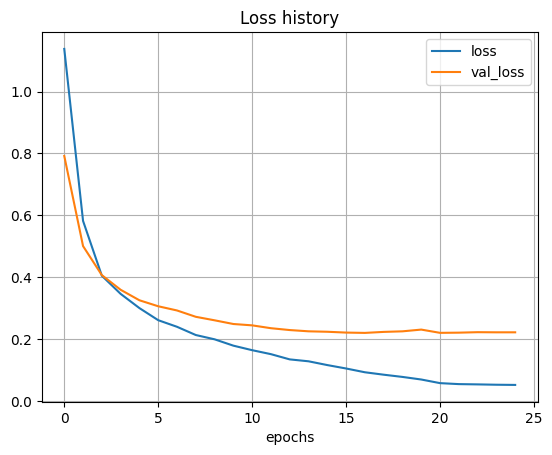

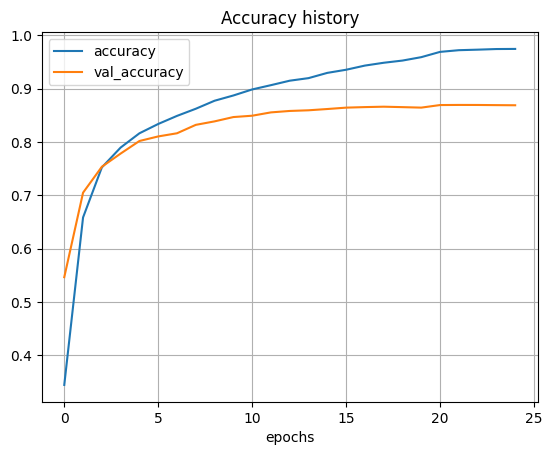

In [71]:
from utils.evaluate import plot_history

plot_history(third_model_history)

### Check the predicted labels on a single test sentence

In [72]:
print('Sentence:', texts_test[0])

Sentence: ['intelogic', 'trace', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '[num]', 'million', 'shares', ',', 'or', 'about', '[num]', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', 'unaffiliated', 'shareholder', 'for', '$', '[num]', 'a', 'share', ',', 'or', '$', '[num]', 'million', '.']


In [73]:
print('True POS tags:', labels_test[0])

True POS tags: ['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.']


In [74]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(third_model(x_test_padded[0:1]), axis=2)][0][:len(labels_test[0])])

Predicted POS tags: ['NN' 'NNPS' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [75]:
third_model.evaluate(x_test_padded, y_test_padded)

20/20 [==============================] - 0s 16ms/step - loss: 0.1279 - accuracy: 0.8784


[0.12792716920375824, 0.8783531785011292]

### F1 macro (no punctuation)

In [178]:
# Val

# y_pred_val = np.argmax(third_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.811


              precision    recall  f1-score   support

          NN       0.83      0.84      0.84      2383
          IN       0.96      0.95      0.95      1630
         NNP       0.86      0.88      0.87      1503
          DT       0.98      0.99      0.98      1335
         NNS       0.84      0.86      0.85       941
          JJ       0.71      0.73      0.72       917
          CD       0.97      0.98      0.98       858
         VBD       0.90      0.86      0.88       634
          RB       0.75      0.77      0.76       381
          VB       0.90      0.94      0.92       403
          CC       0.99      0.98      0.98       364
          TO       1.00      1.00      1.00       386
         VBN       0.75      0.66      0.70       366
         VBZ       0.90      0.89      0.89       280
         PRP       0.97      0.98      0.97       192
         VBG       0.62      0.53      0.57       221
         VBP       0.87      0.78      0.82       134
          MD       0.97    

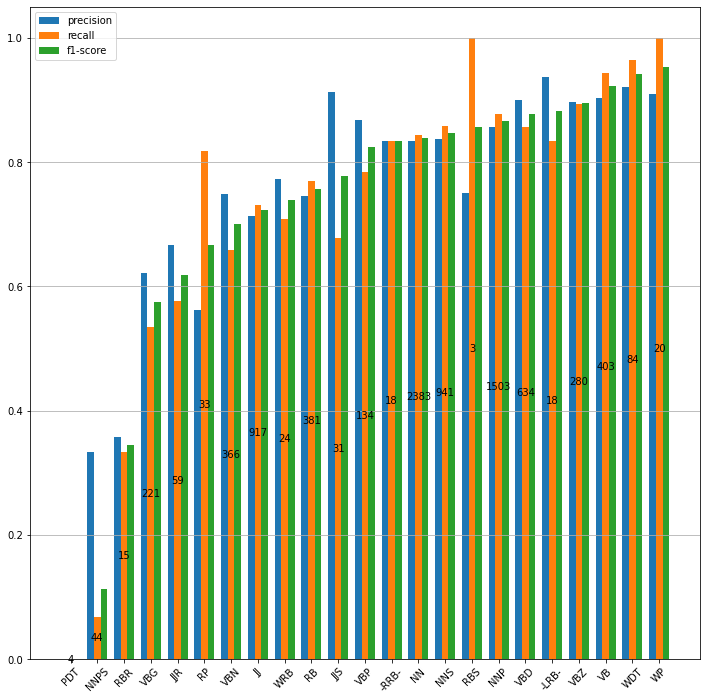

In [180]:
class_report = compute_class_report(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels, show=True, plot=True, k=n_classes//2)

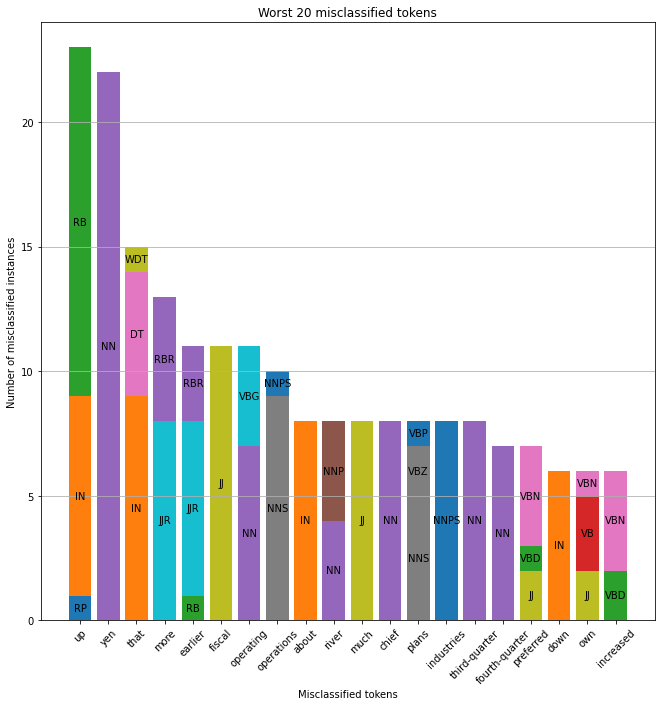

In [181]:
from utils.evaluate import wrongly_classified_tokens_analysis

wrong_tokens_dict, wrong_tokens_tags_df = wrongly_classified_tokens_analysis(x_test_padded, y_true=y_test_padded, y_pred=y_pred_test, 
                                                                       tags_no_evaluate=tags_no_evaluate, vocabulary_labels=vocabulary_labels,
                                                                       vocabulary=vocabulary, plot=True)

In [188]:
from utils.evaluate import wrongly_classified_sentences_analysis
worst_sentences_dict = wrongly_classified_sentences_analysis(x_test_padded, y_test_padded, y_pred_test, tags_no_evaluate, 
                                                             vocabulary_labels, vocabulary, k=5, show=True)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 349
Relative error: 0.60
markets -- stocks : volume[NN/JJ] 154,240,000[CD/JJ] shares[NNS/NN] . 

2) Sentence index 77
Relative error: 0.50
continued[VBN/IN] export demand[NN/NNS] also supported[VBD/VBN] prices . 

3) Sentence index 178
Relative error: 0.50
volume[NN/IN] totaled 11,390,000[CD/JJ] shares . 

4) Sentence index 76
Relative error: 0.44
trading was muted[VBN/JJ] in part[NN/DT] because[IN/NN] of the observance of all[NNP/DT] saints[NNP/NNS] ' day[NNP/IN] across much[JJ/IN] of europe[NNP/NN] . 

5) Sentence index 517
Relative error: 0.44
its cereal[NN/NNP] division[NN/NNP] realized[VBD/RB] higher operating[VBG/VBN] profit on volume[NN/JJ] increases , but also spent[VBD/VBN] more[JJR/RBR] on promotion . 

